In [31]:
import numpy as np
import scipy
from scipy import io
from scipy.io import wavfile
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
sf, x = scipy.io.wavfile.read('test.wav')

16000 (108794,)


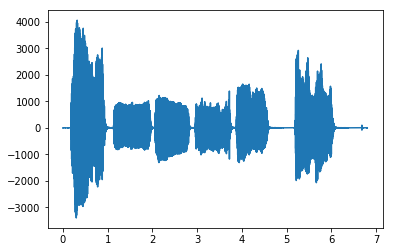

In [33]:
print(sf, x.shape)
t = np.arange(0,x.shape[0]/sf,1/sf)
plt.plot(t,x)

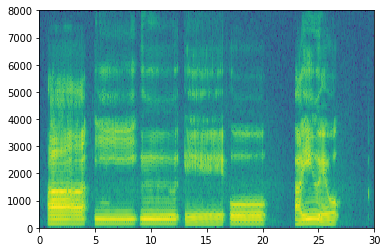

In [34]:
dumy = plt.specgram(x, Fs=sf, xextent=(0,30))

課題（１）：音声信号の一部を拡大して表示してみよう

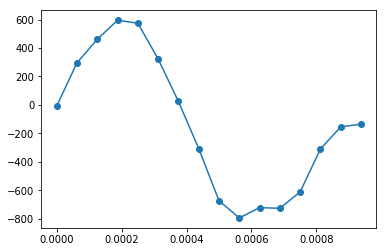

In [35]:
#手法１：サンプリング定理に忠実に

window_width = 16
start = 8004
#start = 300
#start = 0
#window_width = 1024

s = x[start:start+window_width]
#print(s.shape)
t = np.arange(0,s.shape[0]/sf,1/sf)
t = t[0:s.shape[0]]
#print(t)
#print(s)
#print(t.shape)
#plt.plot(t,s,color='black',linestyle='dashed')
plt.plot(t,s,'o-')

サンプリング定理(Sampling Theorem):

$x_{a}(t)$をアナログ信号(analog waveform)とする．
$x_{p}(t)$をインパルス列()とする．
$x[n]$を周期$T$で$x_{a}(t)$(sampling frequency $f_{s}=\frac{1}{T}$}をサンプリングした離散時間信号とする．
これらの信号の関係は以下のようになる．

\begin{eqnarray}
 x[n] &=& x_a(t)|_{t=nT} \\
 x_{p}(t) &=& x_{a}(t)p(t) \\
   &=& \displaystyle \Sigma_{k=-\infty}^{\infty} x_a(kT)\delta(t-kT)
\end{eqnarray}
ここで，帯域制限($f_{N} = 0.5\frac{1}{T}$)を受けたδ関数は
\begin{eqnarray}
 \delta(t) &=& \frac{sin(\pi t/T)}{\pi t/T}
\end{eqnarray}
と表すことができる．
\begin{eqnarray}
 \delta(t-nT) &=& \frac{sin(\pi(t-nT)/T)}{\pi(t-nT)/T}
    &=& \frac{sin(\pi f_{s}(t-nT)}{\pi f_{s}(t-nT)}
    &=& sinc(f_{s}(t-nT))
\end{eqnarray}

(96,)


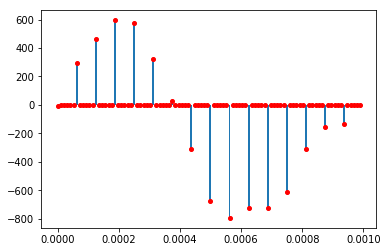

In [36]:
# s -> ss: up倍にサンプル数を増やす（０詰めで）
up = 6
ss = np.zeros(s.shape[0] * up)
ss[::up] = s
print(ss.shape)

#ここがwindow_widthが17だと１個多くなってしまう・・・
#仕方がないので多かったら削ることに．
tt = np.arange(0,s.shape[0]/sf,1/(sf*up))
tt = tt[0:ss.shape[0]]

plt.bar(tt,ss,width=1/sf/10,align='center')
plt.plot(tt,ss,'ro',markersize=4)

(192,)
96 : 1.0


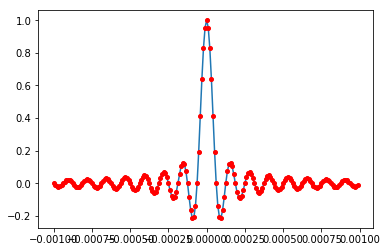

In [37]:
## upsampling前のδ関数をupsampling後のサンプリング周期で描画
## (1) delta関数の準備

# アップサンプリング後の元の信号の２倍の長さの時刻列（時刻０を中心にしているが負がひとつ多い）を用意
t1 = np.arange(-(s.shape[0])/sf, s.shape[0]/sf, 1/(sf*up))
#print(s.shape[0]*up)

## 作成した時系列上でdelta関数を描画
delta = np.sinc(t1*sf)
plt.plot(t1,delta,'-')
plt.plot(t1,delta,'ro',markersize=4)
print(t1.shape)
print(window_width*up, ":", delta[window_width*up])

In [38]:
# ０詰データ ss と同じ長さの波形用データ sss を準備
# ssの範囲外の信号はすべて０と仮定している
sss = np.zeros(ss.shape[0])
# アップサンプリング前の時刻の配列
#t = np.arange(0,s.shape[0]/sf, 1/sf)
# アップサンプリング後の時刻の配列
##tt = np.arange(0,ss.shape[0]/(sf*up),1/(sf*up))

In [39]:
#δ関数を畳み込む（左右対称）
#for i in range(ss.shape[0]):
for i in range(0,ss.shape[0],up):  # ０詰めしたところは跳ばす
#    print(ss.shape[0]-i,":",2*ss.shape[0]-i)
    sss = sss + (ss[i] * delta[ss.shape[0]-i:2*ss.shape[0]-i]) 

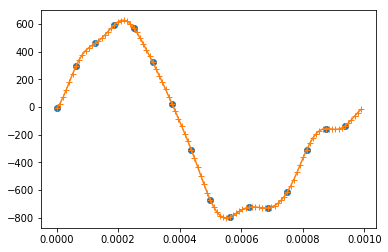

In [40]:
#描画
#print(tt.shape)
#print(ss.shape)
#print(t.shape)
#print(s.shape)
#plt.plot(t[220:240], s[220:240], 'o')
#plt.plot(tt[220*up:240*up], sss[220*up:240*up], '-')
plt.plot(t, s, 'o')
plt.plot(tt, sss, '-+')

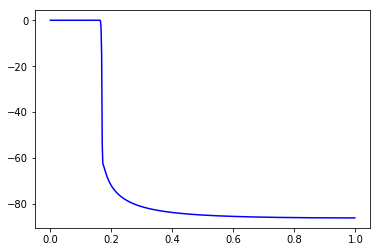

In [41]:
# 手法２：フィルタリングによる方法
import scipy.signal as dsp

# 時間遅れの関係でフィルタのタップ長は奇数が望ましい
n_lpf = 1025

# Nyquist Frequency is 1.0
# Design FIR lowpass filter with cutoff 1/up.
lowpass = dsp.firwin(n_lpf, 1/up)
w, h = dsp.freqz(lowpass)
plt.plot(w/np.pi, 20 * np.log10(abs(h)), 'b')
#plt.stem(filt)

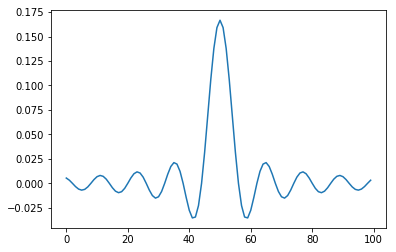

In [42]:
plt.plot(lowpass[int(n_lpf/2-50):int(n_lpf/2+50)])

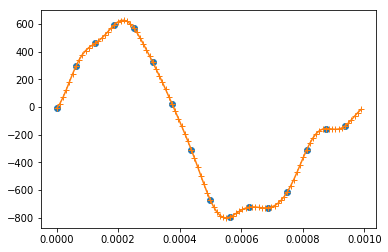

In [43]:
# フィルタの長さ分データを増やしておく
ss_long = np.concatenate((ss,np.zeros(n_lpf)))

# フィルタをかける．FIRなので第２引数は[1]
out = dsp.lfilter(lowpass, [1], ss_long)
#plt.plot(out)
plt.plot(t,s,'o')

# 窓関数設計のローパスフィルターによって発生する遅延はフィルターの中央次数に等しい
# 3の場合は2． 4の場合は2.5なので，サンプリングの間になってしまう．
# (up-1)の分０詰めされているので，up倍する必要がある．
delay = round((n_lpf-1)/2)
plt.plot(tt,up*out[delay:delay+ss.shape[0]],'+-')

(96,)
9 -8


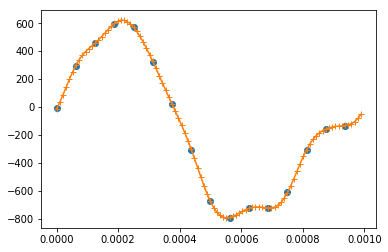

In [44]:
# 手法３：FFTの利用
# デジタルフーリエ変換は周期性を仮定しているため誤差が大きい
import scipy.fftpack as sfft
cs = sfft.fft(ss)
#cs[9:-8] = 0
print(cs.shape)
print(int(window_width/2)+1,-int(window_width/2))
cs[int(window_width/2)+1:-int(window_width/2)] = 0
#print(cs)
#print(cs.shape)
x = sfft.ifft(cs)
plt.plot(t,s,'o')
plt.plot(tt,up*(x.real),'+-')
#print(x)

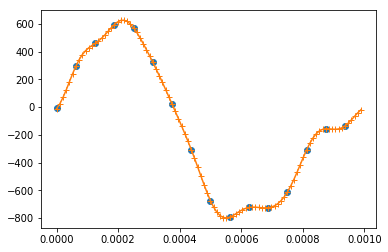

In [45]:
# 前後に信号と同じ長さ０詰することで誤差を軽減
addpoints = ss.shape[0]
ss_long = np.concatenate((np.zeros(addpoints),ss,np.zeros(addpoints)))
cs = sfft.fft(ss_long)

# 高域をすべて０にする
cs[int(window_width/2*3)+1:-int(window_width/2*3)] = 0

x_long = sfft.ifft(cs)

# 元のssに対応する部分を取り出す
x = x_long[addpoints:addpoints+ss.shape[0]]
plt.plot(t,s,'o')
plt.plot(tt,up*(x.real),'+-')